# Trabalho Albúm de Copa
### Integrantes: 
### - Adriel Bombonato Guidini Godinho RA191011631
### - Guilherme Figueiredo Arjona RA181010291

---

## Pré-processamento
Fazer com que apenas o álbum da copa esteja visível e que as resoluções e rotações das imagens estejam padronizadas

In [891]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

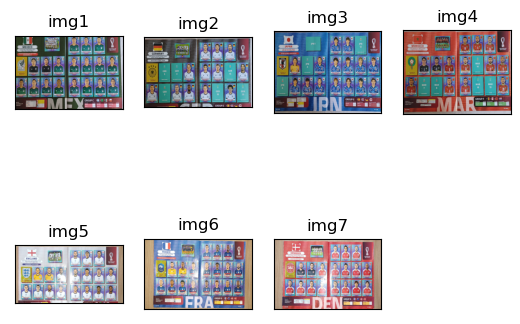

<Figure size 400x400 with 0 Axes>

In [892]:
# Carregar as imagens 
images = [cv2.imread(file) for file in glob.glob("images/*.jpg")]

# Rotacionar e recortar separadamente a img5
images[4] = cv2.rotate(images[4], cv2.ROTATE_90_COUNTERCLOCKWISE)
images[4] = images[4][:,500:]

# Listas para guardar os valores minimos e máximos das bordas dos quadros
px_list = []
py_list = []

# Rotacionar e padronizar o tamanho das imagens
for i in range(len(images)):
    if i == 1 or i == 4:
        pass # excluir casos já solucionados
    else:
        images[i] = cv2.rotate(images[i], cv2.ROTATE_180)

    images[i] = cv2.resize(images[i], (1280,720)) # Padronizar tamanho

    # Recortar bordas do álbum a partir de detecção de linhas de Hough
    edges = cv2.Canny(images[i],50,150,apertureSize = 3)
    rlines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength=480,maxLineGap=17)
    for line in rlines:
        px1,py1,px2,py2 = line[0]
        px_list.append(px1)
        px_list.append(px2)
        py_list.append(py1)
        py_list.append(py2)

    # Imagem recortada conforma míminos e máximos de cada linha que contém o cartão
    images[i] = images[i][min(py_list):max(py_list), min(px_list):max(px_list)]
    px_list = []
    py_list = []

# Plotar todos os resultados
titles = ['img1', 'img2', 'img3', 'img4','img5', 'img6', 'img7']
for i in range(len(images)):
    plt.subplot(2,4,i+1),plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.figure(figsize=(4,4))
plt.show()

## Tentativa de aplicar Histogram Backprojection a partir de uma ROI

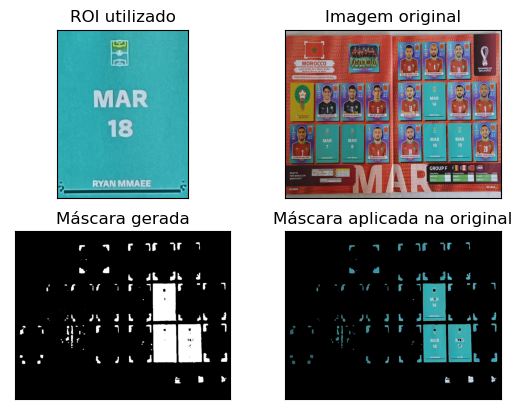

<Figure size 1000x1000 with 0 Axes>

In [893]:
# roi é o objeto ou a região do objeto que queremos procurar
roi = cv2.imread('ROI\\ROI-img4.jpg') # salvando roi como lateral do prédio
hsv = cv2.cvtColor(roi,cv2.COLOR_BGR2HSV)

# target é a imagem em que vai ser feita a busca do objeto
target = images[3]
hsvt = cv2.cvtColor(target,cv2.COLOR_BGR2HSV)

# calcular o histograma do objeto
roihist = cv2.calcHist([hsv],[0, 1], None, [20, 256], [0, 180, 0, 256])

# normalizar histograma e aplicar backprojection
cv2.normalize(roihist,roihist,0,255,cv2.NORM_MINMAX)
dst = cv2.calcBackProject([hsvt],[0,1],roihist,[0,180,0,256],1)

# convolucionar com disco citcular
disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
cv2.filter2D(dst,-1,disc,dst)

# threshold e binary AND
ret,thresh = cv2.threshold(dst,50,255,0)
thresh = cv2.merge((thresh,thresh,thresh))
res = cv2.bitwise_and(target,thresh)

# Plotar todos os resultados
titles = ['ROI utilizado', 'Imagem original', 'Máscara gerada', 'Máscara aplicada na original']
imagens = [roi, target, thresh, res]
for i in range(len(imagens)):
    imagens[i] = cv2.cvtColor(imagens[i], cv2.COLOR_BGR2RGB)
    plt.subplot(2,2,i+1),plt.imshow(imagens[i])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.figure(figsize=(10,10))
plt.show()

O método gera uma máscara que poderia ser utilizada para passos futuros, já que isola suficientemente as figurinhas faltantes. Utilizar Erode e Dilate seria uma boa tentativa. Porém, para esse método, seria necessário isolar uma ROI diferente em cada foto, pois existe diferentes tipos de iluminação que podem gerar erros na identificação da cor esperada. 

Dessa forma, foi utilizada outra alternativa que está representada a seguir.

## Tentativa por segmentação por limites inferiores e superiores

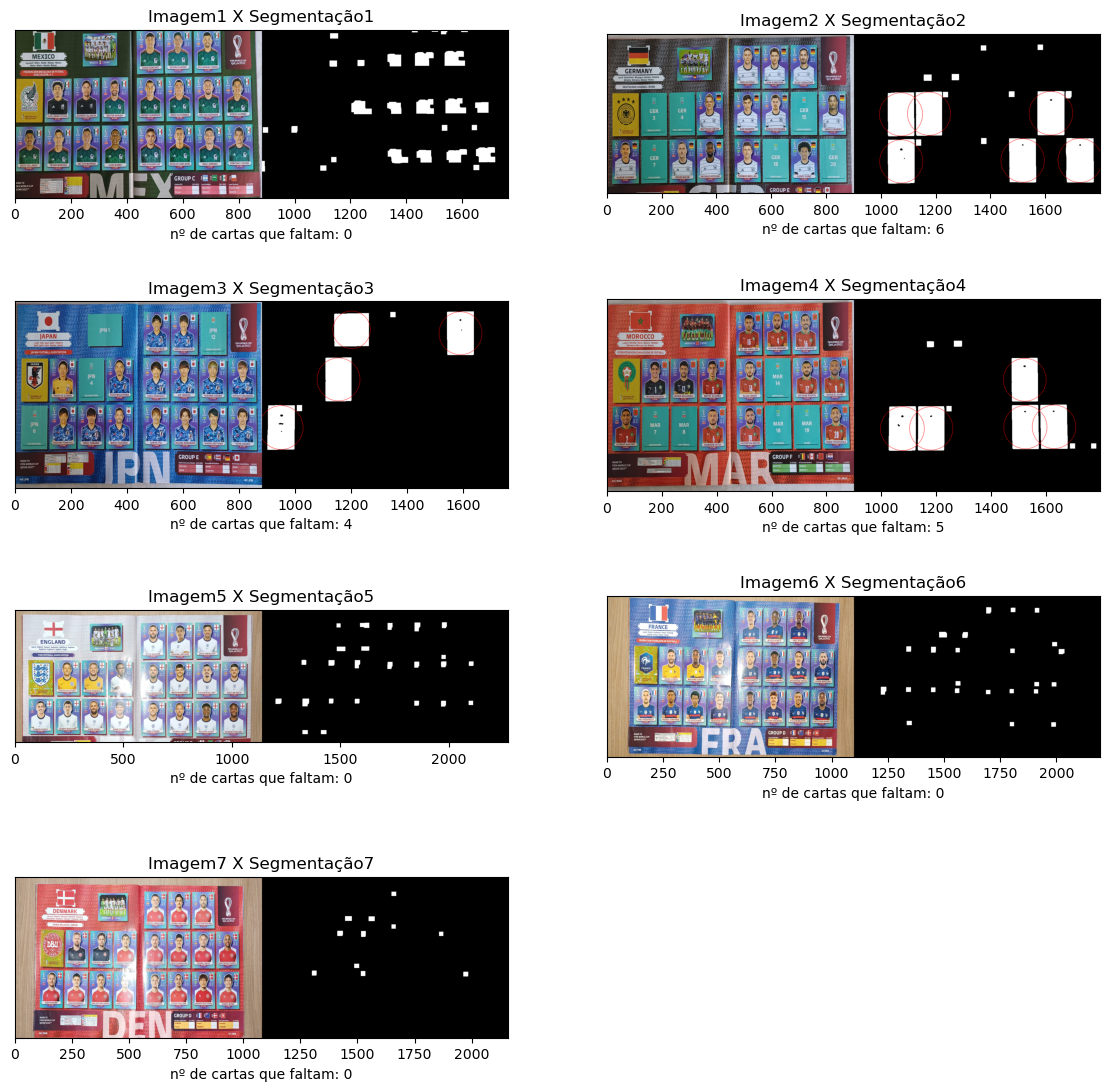

In [894]:
def segmetacao_limites(image):
    # Intervalo de cor em hsv para ser usada na máscara 
    lowerLimit_hsv = (80, 20, 70)
    upperLimit_hsv = (100, 255, 255)
    
    # HSV:
    img = cv2.medianBlur(image, 5) # Filtro na imagem para diminuir ruído
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) # Para HSV

    # Realizar um Threshold na imagem hsv para obter apenas a cor desejada
    mask_hsv_orig = cv2.inRange(img_hsv, lowerLimit_hsv, upperLimit_hsv)

    # Dilatar e corroer a imagem como forma de considerar porções ignoradas da máscara
    mask_hsv = cv2.dilate(mask_hsv_orig, np.ones((5,5))) # tampar os buracos dentro das cartas que faltam

    # Reduzir ruído fora das cartas
    mask_hsv = cv2.erode(mask_hsv, np.ones((11,11))) 
    mask_hsv = cv2.erode(mask_hsv, np.ones((11,11)))

    # Garantir a área correta para o blob detector
    mask_hsv = cv2.dilate(mask_hsv, np.ones((15,15))) 
    mask_hsv = cv2.dilate(mask_hsv, np.ones((5,5)))

    # Operação lógica entre as imagens para excluir tudo que não é a máscara na imagem
    img_segmented_hsv = cv2.bitwise_and(img, img, mask = mask_hsv)
    return mask_hsv

def blob_detector(mask):

    params = cv2.SimpleBlobDetector_Params()

    # Filtrar pela área
    params.filterByArea = True
    params.minArea = 4000
    params.maxArea = 50000

    # Filtrar pela cor
    params.blobColor = 255

    detector = cv2.SimpleBlobDetector_create(params)

    # Detectar blobs 
    keypoints = detector.detect(mask)
    
    # Desenhar blobs
    img_with_keypoints = cv2.drawKeypoints(mask, keypoints, np.array([]),
                                            (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return img_with_keypoints, keypoints

num_keypoints = []

for i in range(len(images)):
    mask_hsv = segmetacao_limites(images[i])
    img_with_keypoints, keypoints = blob_detector(mask_hsv)

    num_keypoints.append(len(keypoints))

    images[i] = np.hstack((images[i], img_with_keypoints))

# Plotar todos os resultados
titles = ['Imagem1 X Segmentação1', 'Imagem2 X Segmentação2', 
            'Imagem3 X Segmentação3', 'Imagem4 X Segmentação4', 
            'Imagem5 X Segmentação5', 'Imagem6 X Segmentação6',
            'Imagem7 X Segmentação7']

plt.figure(figsize=(14,14))
for i in range(len(images)):
    images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
    plt.subplot(4,2,i+1),plt.imshow(images[i])
    plt.title(titles[i])
    plt.xlabel(f'nº de cartas que faltam: {num_keypoints[i]}')
    plt.yticks([])
plt.show()